# Cleaning SimilarWeb ranking data

The data used here was extracted from [SimilarWeb](https://www.similarweb.com/) using the free trial, on 2023-11-28. It contains ranks of websites according to traffic, along with other stats.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl

import xavy.dataframes as xd

## Functions

In [2]:
def stack_columns(df, col_name):
    """
    Given a DataFrame `df` with multiple columns, stack all 
    columns under a single one named `col_name`.
    """
    out_df = pd.melt(df, value_name=col_name).drop('variable', axis=1)
    return out_df

In [3]:
def parse_BM_numbers(series):
    """
    Parse numbers written with 'B' for billions and 'M' for 
    millions in a `series`. Returns a Series.
    """
    
    # Security check:
    str_series = series.astype(str)
    assert str_series.str.contains(r'[0-9BM\-]$', regex=True).sum() == len(series)
    
    # Get significant digits: 
    signif_visits = str_series.replace('([BM])', '', regex=True)
    #signif_visits.loc[signif_visits != '-'] = signif_visits.loc[signif_visits != '-'].astype(float)
    signif_visits.loc[signif_visits == '-'] = np.NaN
    signif_visits = signif_visits.astype(float)
    
    # Create factor series:
    factor_visits = pd.Series(1, index=series.index)
    factor_visits.loc[str_series.str.contains('B')] = 1e9
    factor_visits.loc[str_series.str.contains('M')] = 1e6
    
    # Compute float number:
    parsed_series = signif_visits * factor_visits
    
    return parsed_series

In [4]:
def interleave(s1, s2, block_size, ignore_index=False):
    """
    Mix two series by concatenating segments of a given length.
    
    Parameters
    ----------
    s1 : Series
        First Series to mix (interleave).
    s2 : Series
        Second Series to mix (interleave). It must have the 
        same length as `s1`.
    block_size : int
        Length of segments extracted from `s1` and `s2` that 
        will follow each other. It must be a divisor of 
        the length of `s1`.
    ignore_index : bool
        Whether the resulting Series will have a new sequential
        index or if it will keep the original incides.
    
    Returns
    -------
    result : Series
        The interleaved series `s1` and `s2`, starting with
        `block_size` elements from `s1`, followed by `block_size`
        elements of `s2`, then the next `block_size` from `s1`,
        and so on.
    """
    
    # Security checks:
    assert len(s1) == len(s2)
    assert len(s1) % block_size == 0
    
    n_blocks = int(len(s1) / block_size)
    blocks = []
    for i in range(n_blocks):
        blocks = blocks + [s1.iloc[i*block_size : (i+1)*block_size]] + [s2.iloc[i*block_size : (i+1)*block_size]]
    
    result = pd.concat(blocks, ignore_index=ignore_index)
    
    return result

In [5]:
def clean_rank_df(parsed_cols_df, my_traffic_share=False, page_entries=100):
    """
    Clean a DataFrame of stats for websites scraped from SimilarWeb's 
    Web Category Leaders. The DataFrame columns must be already parsed,
    separated in columns (the scraped data comes all in a single 
    column).
    
    If `my_traffic_share` is True, replace original traffic share 
    by the one computed from monthly visits. This only works if 
    all 10k websites are present in the data.
    
    Returns a DataFrame
    """
    
    # Separate desktop and mobile fractions:
    n_pages  = int(len(parsed_cols_df) / page_entries)
    desktop1 = parsed_cols_df['desktop_vs_mobile_1'].iloc[0::2]
    desktop2 = parsed_cols_df['desktop_vs_mobile_2'].iloc[0::2]
    mobile1  = parsed_cols_df['desktop_vs_mobile_1'].iloc[1::2]
    mobile2  = parsed_cols_df['desktop_vs_mobile_2'].iloc[1::2]
    assert page_entries % 2 == 0, 'I do not know what will happen with an odd number of entries per page when interleaving device fractions.'
    block_size = int(page_entries / 2)
    desktop_series = interleave(desktop1, desktop2, block_size, ignore_index=True)
    mobile_series  = interleave(mobile1,  mobile2,  block_size, ignore_index=True)
    parsed_cols_df['desktop_frac'] = desktop_series#.astype(float)
    parsed_cols_df['mobile_frac']  = mobile_series#.astype(float)
    distilled_df = parsed_cols_df.drop(['desktop_vs_mobile_1', 'desktop_vs_mobile_2'], axis=1)

    # Find non-numerical entries:
    str_desktop_frac = distilled_df['desktop_frac'].astype(str).str.contains('[^0-9.]').fillna(False)
    assert set(distilled_df['desktop_frac'].loc[str_desktop_frac]) - {'< 0.1%'} == set()
    str_mobile_frac = distilled_df['mobile_frac'].astype(str).str.contains('[^0-9.]').fillna(False)
    assert set(distilled_df['mobile_frac'].loc[str_mobile_frac]) - {'< 0.1%'} == set()

    # Compute numerical values from complement:
    derived_desktop_frac = 1 - distilled_df.loc[str_desktop_frac, 'mobile_frac']
    derived_mobile_frac  = 1 - distilled_df.loc[str_mobile_frac, 'desktop_frac']

    # Apply numerical values to device fraction:
    distilled_df.loc[str_desktop_frac, 'desktop_frac'] = derived_desktop_frac
    distilled_df.loc[str_mobile_frac,   'mobile_frac'] = derived_mobile_frac
    distilled_df['desktop_frac'] = distilled_df['desktop_frac'].astype(float)
    distilled_df['mobile_frac']  = distilled_df['mobile_frac'].astype(float)

    assert (distilled_df['desktop_frac'] + distilled_df['mobile_frac'] == 1).all()

    # Set position data type (int):
    distilled_df['position'] = distilled_df['position'].astype(int)

    # Only strings in MoM traffic share is '-' and '> 5,000%':
    assert set(distilled_df['mom_traffic_share'].loc[distilled_df['mom_traffic_share'].astype(str).str.contains('[^0-9.]').fillna(False)]) - {'-', '> 5,000%'} == set()

    # All country ranks start with '#':
    assert distilled_df['country_rank'].str.contains('#').sum() == len(distilled_df)
    # Parse contry rank to int:
    distilled_df['country_rank'] = distilled_df['country_rank'].str.replace('([#,])', '', regex=True)
    distilled_df['country_rank'] = distilled_df['country_rank'].astype(int)

    # Parse BM numbers:
    distilled_df['monthly_visits'] = parse_BM_numbers(distilled_df['monthly_visits'])
    distilled_df['unique_visitors'] = parse_BM_numbers(distilled_df['unique_visitors'])

    # Only string in Traffic share is '< 0.01%':
    assert set(distilled_df['traffic_share'].loc[distilled_df['traffic_share'].astype(str).str.contains('[^0-9.]').fillna(False)]) - {'< 0.01%'} == set()

    if my_traffic_share == True:
    
        # Compute traffic share from visits:
        my_share = distilled_df['monthly_visits'] / distilled_df['monthly_visits'].sum()

        # Test for compatibility between original share and computed share:
        traffic_data_df = distilled_df.loc[~distilled_df['traffic_share'].astype(str).str.contains('<') & ~distilled_df['monthly_visits'].isnull()]
        delta_share = my_share.loc[traffic_data_df.index] - traffic_data_df['traffic_share'].astype(float)
        # Errors are smaller than 0.01%:
        assert delta_share.abs().max() < 0.01 / 100

        # Set computed share as true share:
        distilled_df['traffic_share'] = my_share
    
    # Parse time spent on domain:
    distilled_df['visit_duration'] = pd.to_timedelta(distilled_df['visit_duration'].astype(str)).dt.total_seconds()

    # Set data type for pages per visit:
    distilled_df['pages_visit'] = distilled_df['pages_visit'].astype('float')

    # Parse bounce rate:
    null_bounce = distilled_df['bounce_rate'].astype(str).str.contains('^-$', regex=True)
    distilled_df.loc[null_bounce, 'bounce_rate'] = np.NaN
    distilled_df['bounce_rate'] = distilled_df['bounce_rate'].astype(float)
    
    return distilled_df

In [6]:
def parse_1col_df(industry_df, website_cols, page_entries=100, col_name='data'):
    """
    Parse stacked columns into separate columns.
    
    Parameters
    ----------
    industry_df : DataFrame
        Table with one column containing all data scraped from 
        SimilarWeb's Web Category Leaders.
    website_cols : list-like
        Names of the columns present in SimilarWeb's webpage. 
    page_entries : int
        Number of rows in each column of the original SimilarWeb's 
        table (on their website).
    col_name : str
        Name of the column in `industry_df`.
    
    Returns
    -------
    parsed_cols_df : DataFrame
        The original columns in SimilarWeb's webpage, that were 
        stacked during scraping, are split again into the original
        separate columns.
    """
    
    n_cols = len(website_cols)
    assert len(industry_df) == page_entries * n_cols
    
    parsed_cols_df = pd.concat([industry_df.iloc[i*page_entries:(i+1)*page_entries].reset_index(drop=True).rename({col_name:website_cols[i]}, axis=1) for i in range(n_cols)], axis=1)
    
    return parsed_cols_df

## Cleaning data

In [7]:
raw_file = '../data/raw/rank_scraping_free_trial_2023-11-28.xlsx'

# Which columns are present in the data and must be parsed:
cols_df = pd.read_excel(raw_file, sheet_name='Colunas a parsear')
website_cols = cols_df.loc[cols_df['sheet'] == 'Geral mundo', 'parse_col']
n_cols = len(website_cols)

### All industries

In [8]:
# General ranking of websites, load raw data:
general_rank_df = pd.read_excel(raw_file, sheet_name='Geral mundo', header=None)

In [9]:
# Every 100 rows in the raw data is a column:
page_entries = 100
assert len(general_rank_df) == page_entries * n_cols

In [10]:
# Parse row segments into columns:
parsed_cols_df = pd.concat([stack_columns(general_rank_df.iloc[i*page_entries:(i+1)*page_entries], website_cols.iloc[i]) for i in range(n_cols)], axis=1)

In [11]:
# Clean data:
distilled_df = clean_rank_df(parsed_cols_df, my_traffic_share=True)

In [12]:
xd.print_string_series(cols_df.query('sheet == "Geral mundo"').set_index('parse_col')['explanation'])

position: Ordered by traffic share
domain: Domain, including all meaningful subdomains
traffic_share: Percentage of traffic sent to each player
mom_traffic_share: The month-over-month change in traffic volume
country_rank: Rank is determined by using the number of unique visitors during the last month in the choven timeframe as well as the number of desktop and mobile page views
monthly_visits: Sum of all visits (non-unique) per month analyzed
unique_visitors: The average number of unique visitors (not deduplicated across devices) for the selected time period
desktop_vs_mobile_1: Percent of incoming traffic from desktop vs. mobile. These are interleaved due to the scraping process, and this is the first half
desktop_vs_mobile_2: Percent of incoming traffic from desktop vs. mobile. These are interleaved due to the scraping process, and this is the second half
visit_duration: Average time spent by users per visit
pages_visit: Average pages viewed per visit
bounce_rate: Percentage of visi

In [15]:
#distilled_df.to_csv('../data/cleaned/rank_scraping_free_trial_2023-11-28.csv', index=False)

### Per industry sector

In [13]:
# Ranking of websites per industry sector, load raw data:
sector_rank_df = pd.read_excel(raw_file, sheet_name='Por grande área da indústria', header=0)
sector_rank_df = sector_rank_df.iloc[2:].reset_index(drop=True)

In [14]:
col_name = 'data'
industries = sector_rank_df.columns

# Loop over industries (raw table columns):
ind_dfs = []
for j in range(len(industries)):
    #print(j, ':', industries[j])
    # Select one column:
    industry_df = sector_rank_df[[industries[j]]].rename({industries[j]:col_name}, axis=1)
    # Parse and clean data:
    cleaned_df = clean_rank_df(parse_1col_df(industry_df, website_cols))
    # Add industry name:
    cleaned_df.insert(2, 'industry', industries[j])
    # Append:
    ind_dfs.append(cleaned_df)
industry_df = pd.concat(ind_dfs, ignore_index=True)

### Cross check 

In [21]:
# List domains in general rank:
general_domains = list(distilled_df.query('domain != "Upgrade your Account"')['domain'])

# Test if data in general rank and per industry are the same for common domains:
slice_dep = ['traffic_share', 'position']
for i in range(len(general_domains)):
    ind_df = industry_df.loc[industry_df['domain'] == general_domains[i]]
    gen_df = distilled_df.loc[distilled_df['domain'] == general_domains[i]]
    test = (ind_df.drop(['industry'] + slice_dep, axis=1).reset_index(drop=True) == gen_df.drop(slice_dep, axis=1).reset_index(drop=True)).all(axis=None)
    if test == False:
        display(ind_df)
        display(gen_df)

In [30]:
# Stats for domains serve as fingerprint for them (they are unique):
assert xd.iskeyQ(distilled_df.drop(['domain'] + slice_dep, axis=1))
assert xd.iskeyQ(industry_df.drop(['domain', 'industry'] + slice_dep, axis=1))

In [36]:
key_cols = list(distilled_df.drop(['domain'] + slice_dep, axis=1).columns)

In [54]:
joined_df = distilled_df.join(industry_df.query('domain != "Upgrade your Account"').set_index(key_cols), on=key_cols, rsuffix='_ind', how='outer')

In [61]:
i = 0
joined_df.loc[joined_df['domain'].isnull() | joined_df['domain_ind'].isnull()].sort_values(['monthly_visits', 'country_rank', 'visit_duration', 'bounce_rate', 'desktop_frac']).iloc[i*40:(i+1)*40]

,position,domain,traffic_share,mom_traffic_share,country_rank,monthly_visits,unique_visitors,visit_duration,pages_visit,bounce_rate,desktop_frac,mobile_frac,position_ind,domain_ind,industry,traffic_share_ind
9996,9997.0,Upgrade your Account,0.000004,-,10654,2033000.0,338762.0,154.0,4.74,0.4132,0.338,0.662,NaN,NaN,NaN,NaN
9995,9996.0,Upgrade your Account,0.000005,-,19446,2071000.0,124063.0,582.0,2.37,0.5228,0.001,0.999,NaN,NaN,NaN,NaN
9994,9995.0,Upgrade your Account,0.000005,-,15959,2080000.0,1055000.0,185.0,1.61,0.7859,0.180,0.820,NaN,NaN,NaN,NaN
9993,9994.0,Upgrade your Account,0.000005,-,8468,2093000.0,512729.0,266.0,6.67,0.2637,0.191,0.809,NaN,NaN,NaN,NaN
9992,9993.0,Upgrade your Account,0.000005,-,10571,2101000.0,244706.0,288.0,5.18,0.2859,0.677,0.323,NaN,NaN,NaN,NaN
9991,9992.0,Upgrade your Account,0.000005,-,10885,2106000.0,629590.0,536.0,4.27,0.5768,0.561,0.439,NaN,NaN,NaN,NaN
9989,9990.0,Upgrade your Account,0.000005,-,8558,2124000.0,393568.0,212.0,5.89,0.3275,0.159,0.841,NaN,NaN,NaN,NaN
9990,9991.0,Upgrade your Account,0.000005,-,15038,2124000.0,1508000.0,41.0,1.31,0.7992,0.137,0.863,NaN,NaN,NaN,NaN
9988,9989.0,Upgrade your Account,0.000005,26.8875,9465,2130000.0,332544.0,645.0,7.95,0.3905,0.425,0.575,NaN,NaN,NaN,NaN
9987,9988.0,Upgrade your Account,0.000005,-,12057,2132000.0,1318000.0,293.0,2.52,0.5274,0.113,0.887,NaN,NaN,NaN,NaN


In [49]:
len(industry_df.query('domain != "Upgrade your Account"'))

1800

In [47]:
got_name_df = joined_df.query('domain != domain_ind').dropna()
got_name_df['domain'].value_counts()

Upgrade your Account    1581
Name: domain, dtype: int64

## Analysis

### Visit duration

In [27]:
# Duration in minutes:
(distilled_df['visit_duration'] / 60).describe()

count    9997.000000
mean        4.821902
std         4.414912
min         0.000000
25%         2.150000
50%         3.766667
75%         6.116667
max       139.650000
Name: visit_duration, dtype: float64

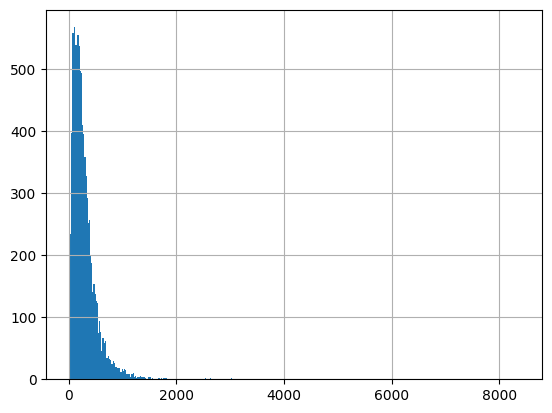

In [24]:
distilled_df['visit_duration'].dropna().hist(bins=400)
#pl.yscale('log')
pl.show()

### Monthly visits rank

In [74]:
from sklearn.linear_model import LinearRegression

In [75]:
# Get montlhy visits rank data:
avg_visits = distilled_df['monthly_visits'].dropna().values
pos = np.arange(1, 1 + len(avg_visits))

# Fit power law model:
linear_fit = LinearRegression()
dump  = linear_fit.fit(np.transpose([np.log(pos)]), np.log(avg_visits))
V0    = np.exp(linear_fit.intercept_) # Scale
beta  = linear_fit.coef_[0]           # Exponent

In [76]:
def power_visits(p, V0, beta):
    """
    Estimate the number of monthly visits a website gets
    when at position `p` in a traffic-share rank.
    """
    return V0 * p ** beta

def Tint(N, V0, beta):
    """
    Compute the total monthly visits for `N` domains given
    a power law model and the integral approximation.
    """
    Taprox = V0 / (beta + 1) * ((N + 1) ** (beta + 1) - 1) + V0 / 2
    return Taprox

Let's compare the monthly visits given by the data with the power law model fit:

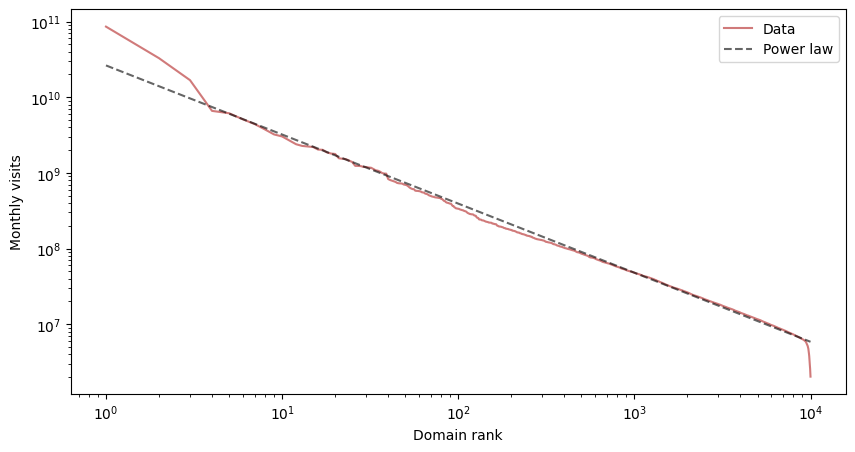

In [77]:
pl.figure(figsize=(10,5))
# Plot data:
pl.plot(pos, avg_visits, alpha=0.6, color='firebrick', label='Data')
# Plot model:
x = np.logspace(0,4,100)
y = power_visits(x, V0, beta)
pl.plot(x, y, alpha=0.6, color='k', linestyle='--', label='Power law')
# Format:
pl.yscale('log')
pl.xscale('log')
pl.ylabel('Monthly visits')
pl.xlabel('Domain rank')
pl.legend()
pl.show()

To compute the total monthly visits for many websites, it is easier to approximate the sum over the domain's monthly visits by an integral. We will compare the total monthly visits given the data with the one obtained by summing the power law model, and then to the integral of the power law model:

In [107]:
N = 10000

# Compute the total monthly visits given the model:
xpower = np.arange(1, N + 1)
Tpower = (V0 * xpower ** exponent).sum()

# Compute the total monthly visits given the model and the integral approx:
Taprox = Tint(N, V0, beta)
assert np.abs(Tpower - Taprox) < V0 / 2

# Compute the total monthly visits from the data:
Tdata = distilled_df['monthly_visits'].sum()

# Total monthly visits for 10k websites, compare data, power law model and integral approx. results:
pd.Series([Tdata, Tpower, Taprox], index=['data', 'model', 'integral'])

data        4.597742e+11
model       3.867261e+11
integral    3.848641e+11
dtype: float64

We see above that the error made by the integral approximation is much smaller than the error made by the power law model. This justifies the usage of the integral approximation.

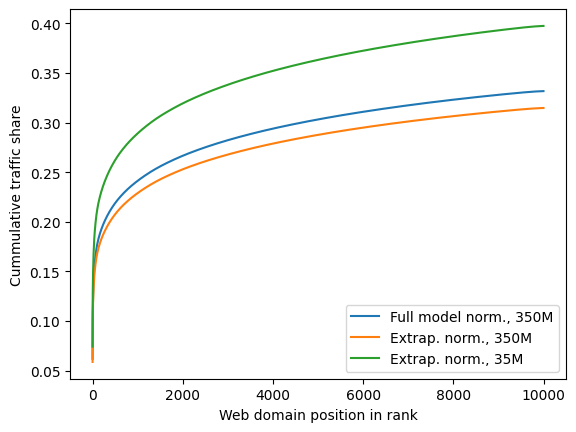

In [109]:
T0p1    = Tint(35e6, V0, beta)
Tall    = Tint(350e6, V0, beta)
Textrap = Tall - Tint(n_data, V0, beta) + Tdata
Te0p1   = T0p1 - Tint(n_data, V0, beta) + Tdata
cumtraffic_all    = np.cumsum(distilled_df['monthly_visits'].dropna() / Tall)
cumtraffic_extrap = np.cumsum(distilled_df['monthly_visits'].dropna() / Textrap)
cumtraffic_e0p1   = np.cumsum(distilled_df['monthly_visits'].dropna() / Te0p1)
pl.plot(cumtraffic_all, label='Full model norm., 350M')
pl.plot(cumtraffic_extrap, label='Extrap. norm., 350M')
pl.plot(cumtraffic_e0p1,   label='Extrap. norm., 35M')
pl.ylabel('Cummulative traffic share')
pl.xlabel('Web domain position in rank')
pl.legend()
pl.show()

In [110]:
# Estimate of the minimum number of visits to figure in the top 10k websites tracked by SimilarWeb: 
power_visits(1e4, V0, beta)

5866101.343723187

#### Analysis of the last domains in rank

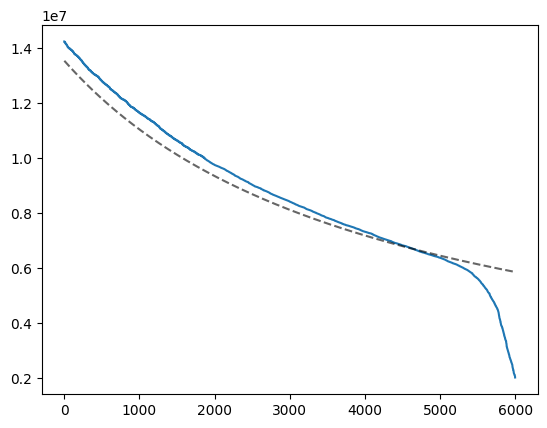

In [84]:
last_n = 6000
pl.plot(distilled_df['monthly_visits'].dropna().iloc[-last_n:].values)
x = np.arange(1, 1 + last_n)
y = power_visits(10000 - last_n + x, V0, beta)
pl.plot(x, y, alpha=0.6, color='k', linestyle='--', label='Power law')
pl.show()


## Exploring the data

### Traffic share

In [89]:
less_traffic = (distilled_df['traffic_share'] == '< 0.01%')
less_traffic.sum()

8939

In [91]:
distilled_df['traffic_share'].loc[~less_traffic].sum()

0.728899999999982

<Axes: >

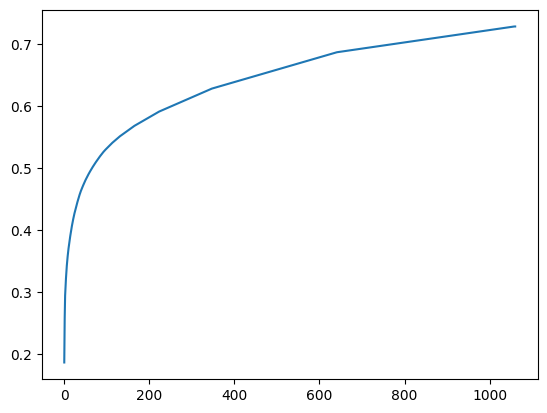

In [98]:
np.cumsum(distilled_df['traffic_share'].loc[~less_traffic]).reset_index(drop=True).plot()

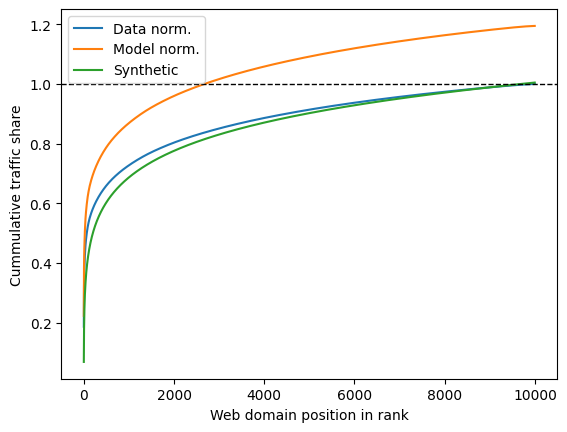

In [98]:
# Compare the traffic share given a normalization by the data or the model:
n_data = len(distilled_df['monthly_visits'].dropna())
pl.plot(np.cumsum(distilled_df['traffic_share'].values), label='Data norm.')
pl.plot(np.cumsum(distilled_df['monthly_visits'].values / Tint(1e4, V0, beta)), label='Model norm.')
pl.plot(np.cumsum(power_visits(np.arange(1, 1 + n_data), V0, beta) / Tint(1e4, V0, beta)), label='Synthetic')
pl.axhline(1, color='k', linestyle='--', linewidth=1)
pl.ylabel('Cummulative traffic share')
pl.xlabel('Web domain position in rank')
pl.legend()
pl.show()

## Questions about the data

* The number of monthly visits for the last 500 in traffic share rank drop significantly. Why does this happen? Is it difficulty in the data collection? If so, what are the difficulties?
* What are the methods of data collection? Add-ons, partnership with clients? Anything else?
